In [ ]:
!pip install pandas sqlalchemy openpyxl requests gspread gdown

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import requests


In [ ]:
!pip install Faker

In [ ]:
import pandas as pd
from faker import Faker
import random
import datetime

fake = Faker()

NUM_RECORDS = 4000

STATUS_OPTIONS = ['Confirmado', 'Pendiente', 'Cancelado', 'No-mostar', 'CONFIRMADO', 'confirmado', 'cancelado', 'Pendiente ', ' Confirmado']
PLATFORM_OPTIONS = ['Sitio', 'Telegono', 'Aplicacion', 'En-linea', 'Llamada', 'Aplicacion-movil', ' sitioweb', 'telefono']
TIME_FORMATS = ['%H:%M', '%I:%M %p', '%H:%M:%S']
DATE_FORMATS = ['%Y-%m-%d', '%d/%m/%Y', '%m-%d-%Y', '%d-%b-%Y']
BAD_EMAIL_SUFFIXES = ['@example', '.com', '@.com', '@email..com']

def introduce_dirt(record):

    if random.random() < 0.1: record['Correo'] = ''
    if random.random() < 0.15: record['Numero'] = None
    if random.random() < 0.2: record['Especificaciones'] = ''

    if random.random() < 0.05: record['Nombre'] = record['Nombre'].replace(random.choice(record['Nombre']), '')
    if random.random() < 0.05: record['Apellido'] = record['Apellido'].lower()

    record['DiaReservacion'] = record['DiaReservacion'].strftime(random.choice(DATE_FORMATS))
    record['HoraReservacion'] = record['HoraReservacion'].strftime(random.choice(TIME_FORMATS))

    if record['Numero']:
        phone = str(record['Numero'])
        if random.random() < 0.3: record['Numero'] = f"({phone[:3]}) {phone[3:6]}-{phone[6:]}"
        elif random.random() < 0.3: record['Numero'] = f"{phone[:3]}-{phone[3:6]}-{phone[6:]}"

    if record['Correo'] and random.random() < 0.1:
        record['Correo'] = record['Correo'].split('@')[0] + random.choice(BAD_EMAIL_SUFFIXES)

    if random.random() < 0.02: record['NAsistentes'] = random.choice([0, 99, 100])

    if random.random() < 0.1: record['Especificaciones'] = f" {record['Especificaciones']} "

    return record

data = []
for i in range(1, NUM_RECORDS + 1):
    reservation_date = fake.date_between(start_date='-30d', end_date='+60d')
    reservation_time = datetime.time(random.randint(12, 22), random.choice([0, 15, 30, 45]))

    record = {
        'ReservacionID': i,
        'CustomerID': f'CUST{random.randint(1, NUM_RECORDS // 2)}', # Forzar duplicados de clientes
        'Nombre': fake.first_name(),
        'Apellido': fake.last_name(),
        'Correo': fake.email(),
        'Numero': fake.msisdn()[:10],
        'DiaReservacion': reservation_date,
        'HoraReservacion': reservation_time,
        'NAsistentes': random.randint(1, 10),
        'Especificaciones': fake.sentence(nb_words=5) if random.random() > 0.5 else '',
        'Mesa': random.randint(1, 30),
        'Estado': random.choice(STATUS_OPTIONS),
        'PlataformaReserva': random.choice(PLATFORM_OPTIONS)
    }

    dirty_record = introduce_dirt(record)
    data.append(dirty_record)

for _ in range(int(NUM_RECORDS * 0.05)):
    data.append(random.choice(data))

df = pd.DataFrame(data)

file_name = 'reservaciones.csv'
df.to_csv(file_name, index=False, encoding='utf-8')

print(f"¡Éxito! Se ha creado el archivo '{file_name}' con {len(data)} registros.")

In [ ]:
import os

os.listdir('/content')


In [ ]:
import pandas as pd

df = pd.read_csv('/content/reservaciones.csv', encoding='utf-8', on_bad_lines='skip')

df.head()


In [ ]:
df.info()
df.describe(include='all')
df.isnull().sum()

In [ ]:
import pandas as pd
import numpy as np

try:
    df = pd.read_csv('reservaciones.csv')
    print("Dataset cargado exitosamente.")
    print(f"Número de registros iniciales: {len(df)}")
except FileNotFoundError:
    print("El archivo 'reservaciones.csv' no se encontró. Asegúrate de que esté en la misma carpeta.")
    exit()

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print("\n Iniciando proceso de limpieza y transformación...")

df.drop_duplicates(inplace=True)

df['nombre'] = df['nombre'].str.strip().str.title()
df['apellido'] = df['apellido'].str.strip().str.title()

df['correo'] = df['correo'].str.strip().str.lower()
df['correo'].fillna('no_proporcionado', inplace=True)

df['correo_valido'] = df['correo'].apply(lambda x: True if '@' in x and '.' in x.split('@')[1] else False)

df['numero'] = df['numero'].astype(str).str.replace(r'\D', '', regex=True)
df['numero'].replace('nan', 'no_proporcionado', inplace=True)

estado_map = {
    'confirmado': 'Confirmado', 'pendiente': 'Pendiente', 'cancelado': 'Cancelado',
    'no-mostar': 'No Presentado', 'no-presentado': 'No Presentado',
    'pendiente ': 'Pendiente', ' confirmado': 'Confirmado'
}
plataforma_map = {
    'sitio': 'Sitio Web', 'telegono': 'Teléfono', 'aplicacion': 'App',
    'en-linea': 'Sitio Web', 'llamada': 'Teléfono', 'aplicacion-movil': 'App',
    ' sitioweb': 'Sitio Web', 'telefono': 'Teléfono'
}
df['estado'] = df['estado'].str.strip().str.lower().map(estado_map).fillna('Desconocido')
df['plataformareserva'] = df['plataformareserva'].str.strip().str.lower().map(plataforma_map).fillna('Otra')

df['fechahora_reservacion'] = pd.to_datetime(
    df['diareservacion'].astype(str) + ' ' + df['horareservacion'].astype(str),
    errors='coerce'
)
df.dropna(subset=['fechahora_reservacion'], inplace=True)
df.drop(['diareservacion', 'horareservacion'], axis=1, inplace=True)

df['nasistentes'] = pd.to_numeric(df['nasistentes'], errors='coerce')
df.loc[(df['nasistentes'] <= 0) | (df['nasistentes'] > 20), 'nasistentes'] = np.nan
median_asistentes = df['nasistentes'].median()
df['nasistentes'].fillna(median_asistentes, inplace=True)
df['nasistentes'] = df['nasistentes'].astype(int)

df['especificaciones'].fillna('Ninguna', inplace=True)

df.sort_values(by='fechahora_reservacion', ascending=True, inplace=True)

columnas_finales = [
    'reservacionid', 'customerid', 'nombre', 'apellido', 'correo',
    'correo_valido', 'numero', 'fechahora_reservacion', 'nasistentes',
    'mesa', 'estado', 'plataformareserva', 'especificaciones'
]
df = df[columnas_finales]

print("¡Limpieza completada!")
print(f"Número de registros finales: {len(df)}")

output_filename = 'reservaciones_limpias.csv'
df.to_csv(output_filename, index=False, encoding='utf-8')
print(f"\n Dataset limpio guardado como '{output_filename}'.")

print("\nVista previa del dataset limpio:")
print(df.head())

In [ ]:
import pandas as pd
import numpy as np

try:
    df = pd.read_csv('reservaciones.csv')
    print("Dataset cargado exitosamente.")
    print(f"Número de registros iniciales: {len(df)}")
except FileNotFoundError:
    print("Error: El archivo 'reservaciones.csv' no se encontró. Asegúrate de que esté en la misma carpeta.")
    exit()

print("\n Iniciando proceso de limpieza y transformación...")

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

df.drop_duplicates(inplace=True)

df['nombre'] = df['nombre'].str.strip().str.title()
df['apellido'] = df['apellido'].str.strip().str.title()

df['correo'] = df['correo'].str.strip().str.lower()
df['correo'].fillna('no_proporcionado', inplace=True)
df['correo_valido'] = df['correo'].apply(lambda x: True if '@' in x and '.' in x.split('@')[1] else False)

df['numero'] = df['numero'].astype(str).str.replace(r'\D', '', regex=True)
df['numero'].replace('nan', 'no_proporcionado', inplace=True)

estado_map = {
    'confirmado': 'Confirmado', 'pendiente': 'Pendiente', 'cancelado': 'Cancelado',
    'no-mostar': 'No Presentado', 'no-presentado': 'No Presentado',
    'pendiente ': 'Pendiente', ' confirmado': 'Confirmado'
}
plataforma_map = {
    'sitio': 'Sitio Web', 'telegono': 'Teléfono', 'aplicacion': 'App',
    'en-linea': 'Sitio Web', 'llamada': 'Teléfono', 'aplicacion-movil': 'App',
    ' sitioweb': 'Sitio Web', 'telefono': 'Teléfono'
}
df['estado'] = df['estado'].str.strip().str.lower().map(estado_map).fillna('Desconocido')
df['plataformareserva'] = df['plataformareserva'].str.strip().str.lower().map(plataforma_map).fillna('Otra')

df['fechahora_reservacion'] = pd.to_datetime(
    df['diareservacion'].astype(str) + ' ' + df['horareservacion'].astype(str),
    errors='coerce'
)

df.drop(['diareservacion', 'horareservacion'], axis=1, inplace=True)

df['nasistentes'] = pd.to_numeric(df['nasistentes'], errors='coerce')
df.loc[(df['nasistentes'] <= 0) | (df['nasistentes'] > 20), 'nasistentes'] = np.nan
median_asistentes = df['nasistentes'].median()
df['nasistentes'].fillna(median_asistentes, inplace=True)
df['nasistentes'] = df['nasistentes'].astype(int)

df['especificaciones'].fillna('Ninguna', inplace=True)

df.sort_values(by='reservacionid', ascending=True, inplace=True)

columnas_finales = [
    'reservacionid', 'customerid', 'nombre', 'apellido', 'correo',
    'correo_valido', 'numero', 'fechahora_reservacion', 'nasistentes',
    'mesa', 'estado', 'plataformareserva', 'especificaciones'
]
df = df[columnas_finales]

print(" ¡Limpieza completada!")
print(f"Número de registros finales: {len(df)}")

output_filename = 'reservaciones_limpias_v2.csv'
df.to_csv(output_filename, index=False, encoding='utf-8')
print(f"\n Dataset limpio guardado como '{output_filename}'.")

print("\nVista previa del dataset limpio y ordenado por ID:")
print(df.head())

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

try:
    df = pd.read_csv('reservaciones_limpias.csv')
except FileNotFoundError:
    print("Error: No se encontró 'reservaciones_limpias.csv'. Súbelo a Colab.")
    exit()

df['es_no_presentado'] = df['estado'].apply(lambda x: 1 if x == 'No Presentado' else 0)

df['fechahora_reservacion'] = pd.to_datetime(df['fechahora_reservacion'], errors='coerce')

df = df.dropna(subset=['fechahora_reservacion'])

df['dia_de_semana'] = df['fechahora_reservacion'].dt.dayofweek
df['hora_del_dia'] = df['fechahora_reservacion'].dt.hour
df['mes_del_anio'] = df['fechahora_reservacion'].dt.month

y = df['es_no_presentado']
X = df[['plataformareserva', 'nasistentes', 'mesa', 'dia_de_semana', 'hora_del_dia', 'mes_del_anio']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Datos listos para el modelo:")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print("\nDistribución de la variable objetivo en el set de entrenamiento:")
print(y_train.value_counts(normalize=True))

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

categorical_features = ['plataformareserva']
numeric_features = ['nasistentes', 'mesa', 'dia_de_semana', 'hora_del_dia', 'mes_del_anio']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

print("\nEntrenando Regresión Logística...")
pipeline_lr.fit(X_train, y_train)
print("Modelo de Regresión Logística entrenado.")

print("\nEntrenando Random Forest...")
pipeline_rf.fit(X_train, y_train)
print("Modelo de Random Forest entrenado.")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

print("\n--- Evaluación: Regresión Logística ---")
print(classification_report(y_test, y_pred_lr, target_names=['Se Presentará (0)', 'No Presentado (1)']))
print("Matriz de Confusión (Regresión Logística):")
print(confusion_matrix(y_test, y_pred_lr))

print("\n--- Evaluación: Random Forest ---")
print(classification_report(y_test, y_pred_rf, target_names=['Se Presentará (0)', 'No Presentado (1)']))
print("Matriz de Confusión (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

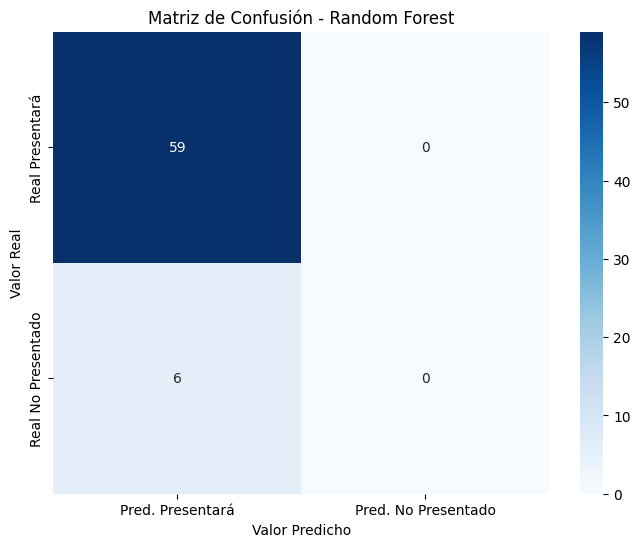

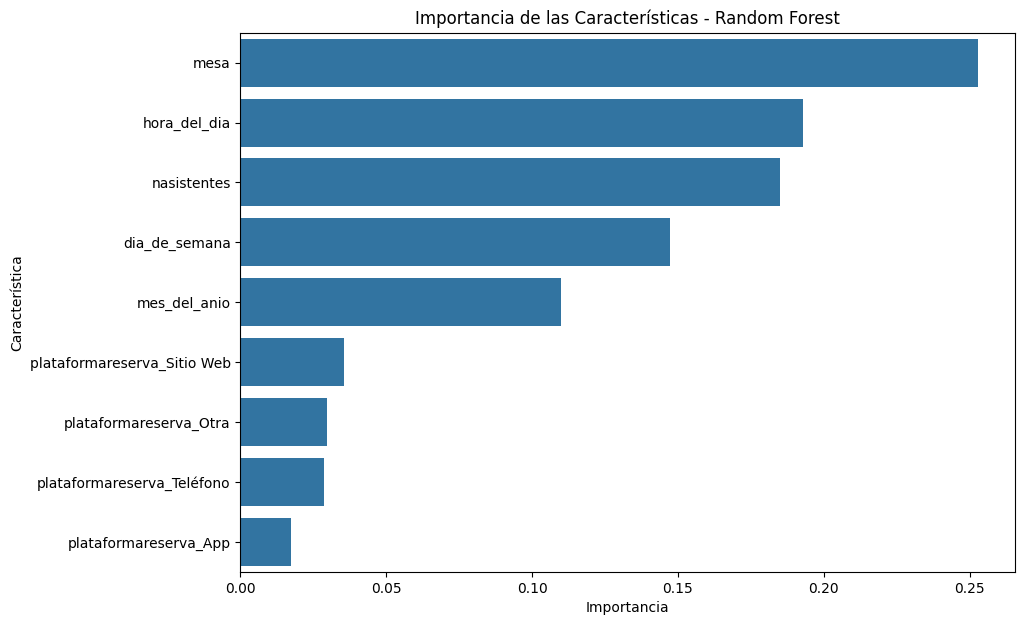

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred. Presentará', 'Pred. No Presentado'],
            yticklabels=['Real Presentará', 'Real No Presentado'])
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.savefig('matriz_confusion.png')
plt.show()

ohe_features = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(ohe_features)

importances = pipeline_rf.named_steps['classifier'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importancia de las Características - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.savefig('importancia_caracteristicas.png')
plt.show()